# Установка и загрузка библиотек

In [1]:
! pip install geopandas
! pip install catboost

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 15.4 MB 39 kB/s 
     |████████████████████████████████| 6.3 MB 52.6 MB/s 
     |████████████████████████████████| 76.3 MB 20 kB/s 


In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import geopandas as gpd
import pickle
import geopy.distance
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor

import ipywidgets as wg
from IPython.display import display
import datetime

from google.colab import drive
drive.mount('/gdrive' )

Mounted at /gdrive


# Применение модели в прототипе приложения

## Подгрузка датасетов и модели, задание функции

In [3]:
flights = pd.read_csv('/gdrive/My Drive/flights_final.csv')
airports = pd.read_csv('/gdrive/My Drive/airports_new.csv')
airlines = pd.read_csv('/gdrive/My Drive/airlines.csv')
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
G = nx.read_gml('/gdrive/My Drive/airport_net.gml')
cb_reg = CatBoostRegressor()
cb_reg.load_model('/gdrive/My Drive/model.cbm')

In [4]:
def delay_predict(aip_out, year, month, day, hour, aip_in=None, airline=None, minute=None):
    if aip_in is None:
      df = flights.query('ORIGIN_AIRPORT == @aip_out')
      df_agg = df.groupby('DESTINATION_AIRPORT',
                          as_index=False).agg({'HOUR': lambda x: hour,
                                        'MINUTE': lambda x: minute if minute is not None else 0,
                                        'TAXI_OUT': 'median',
                                        'TAXI_IN': 'median',	
                                        'SCHEDULED_TIME': 'median',
                                        'DISTANCE': lambda x: x.value_counts().index[0],
                                        'LATITUDE_ORIG': lambda x: x.value_counts().index[0],
                                        'LONGITUDE_ORIG': lambda x: x.value_counts().index[0],
                                        'LATITUDE_DEST': lambda x: x.value_counts().index[0],
                                        'LONGITUDE_DEST': lambda x: x.value_counts().index[0],
                                        'ORIGIN_AIRPORT_DEG': lambda x: x.value_counts().index[0],
                                        'ORIGIN_AIRPORT_CLS': lambda x: x.value_counts().index[0],
                                        'ORIGIN_AIRPORT_BTW': lambda x: x.value_counts().index[0],
                                        'DESTINATION_AIRPORT_DEG': lambda x: x.value_counts().index[0],
                                        'DESTINATION_AIRPORT_CLS': lambda x: x.value_counts().index[0],
                                        'DESTINATION_AIRPORT_BTW': lambda x: x.value_counts().index[0],
                                        'EDGE_BTW': lambda x: x.value_counts().index[0],
                                        'MONTH': lambda x: month,
                                        'DAY': lambda x: day,
                                        'AIRLINE': lambda x: airline if airline is not None else x.value_counts().index[0]})
      
      df_agg['DAY_OF_WEEK'] = datetime.date(year, month, day).weekday() + 1
      df_agg['WEEKEND'] = np.where((df_agg['DAY_OF_WEEK'].values == 6) | (df_agg['DAY_OF_WEEK'].values == 7), 1, 0)
      df_agg['pred_DEL'] = cb_reg.predict(df_agg[cb_reg.feature_names_])
      res = df_agg.sort_values('pred_DEL').iloc[:3].merge(airports,
                                                          left_on='DESTINATION_AIRPORT',
                                                          right_on='IATA_CODE')[['DESTINATION_AIRPORT','AIRPORT',
                                                                                 'CITY', 'STATE', 'pred_DEL']]
      fig, ax = plt.subplots(figsize=(10,8))
      countries.query('name == "United States of America"').plot(color="lightgrey", ax=ax)
      pos = nx.get_node_attributes(G, 'location')
      nx.draw_networkx_nodes(G, pos, [aip_out, *res.DESTINATION_AIRPORT.values], node_size=100, alpha=0.6, label=True, ax=ax)
      nx.draw_networkx_labels(G, pos, labels={v: v for v in [aip_out, *res.DESTINATION_AIRPORT.values]}, alpha=0.8, font_size=10)
      nx.draw_networkx_edges(G, pos, edgelist=[(aip_out, aip) for aip in res.DESTINATION_AIRPORT.values],
                             edge_color='r', alpha=0.4, width=1, node_size=100, ax=ax)

      if len(df_agg) <= 3:
        print('Отсюда можно улететь только по {} направлению/ям'.format(len(df_agg)))
      else:
        print('Из данного аэропорта можно улететь по {} направлению/ям, вот топ 3 с минимальными опозданиями:'.format(len(df_agg)))
      return res

    else:
      fig, ax = plt.subplots(figsize=(10,8))
      countries.query('name == "United States of America"').plot(color="lightgrey", ax=ax)
      pos = nx.get_node_attributes(G, 'location')
      nx.draw_networkx_nodes(G, pos, [aip_out, aip_in], node_size=100, alpha=0.6, label=True, ax=ax)
      nx.draw_networkx_labels(G, pos, labels={v: v for v in [aip_out, aip_in]}, alpha=0.8, font_size=10)
      nx.draw_networkx_edges(G, pos, edgelist=[(aip_out, aip_in)],
                              edge_color='r', alpha=0.4, width=1, node_size=100, ax=ax)
      
      df = flights.query('ORIGIN_AIRPORT == @aip_out and DESTINATION_AIRPORT == @aip_in')
      if airline is None:
        df_agg = df.groupby('AIRLINE',
                          as_index=False).agg({'HOUR': lambda x: hour,
                                        'MINUTE': lambda x: minute if minute is not None else 0,
                                        'TAXI_OUT': 'median',
                                        'TAXI_IN': 'median',	
                                        'SCHEDULED_TIME': 'median',
                                        'DISTANCE': lambda x: x.value_counts().index[0],
                                        'LATITUDE_ORIG': lambda x: x.value_counts().index[0],
                                        'LONGITUDE_ORIG': lambda x: x.value_counts().index[0],
                                        'LATITUDE_DEST': lambda x: x.value_counts().index[0],
                                        'LONGITUDE_DEST': lambda x: x.value_counts().index[0],
                                        'ORIGIN_AIRPORT_DEG': lambda x: x.value_counts().index[0],
                                        'ORIGIN_AIRPORT_CLS': lambda x: x.value_counts().index[0],
                                        'ORIGIN_AIRPORT_BTW': lambda x: x.value_counts().index[0],
                                        'DESTINATION_AIRPORT_DEG': lambda x: x.value_counts().index[0],
                                        'DESTINATION_AIRPORT_CLS': lambda x: x.value_counts().index[0],
                                        'DESTINATION_AIRPORT_BTW': lambda x: x.value_counts().index[0],
                                        'EDGE_BTW': lambda x: x.value_counts().index[0],
                                        'MONTH': lambda x: month,
                                        'DAY': lambda x: day})

        df_agg['DAY_OF_WEEK'] = datetime.date(year, month, day).weekday() + 1
        df_agg['WEEKEND'] = np.where((df_agg['DAY_OF_WEEK'].values == 6) | (df_agg['DAY_OF_WEEK'].values == 7), 1, 0)
        df_agg['pred_DEL'] = cb_reg.predict(df_agg[cb_reg.feature_names_])

        if len(df_agg) <= 3:
          print('Отсюда можно улететь только {} авиакомпаниями/ей'.format(len(df_agg)))
        else:
          print('Из данного аэропорта можно улететь {} авиакомпаниями/ей, вот топ 3 с минимальными опозданиями:'.format(len(df_agg)))
        return df_agg.sort_values('pred_DEL').iloc[:3].merge(airlines, left_on='AIRLINE', right_on='IATA_CODE')[['AIRLINE_x', 'AIRLINE_y', 'pred_DEL']]

      else:
        df_agg = df.groupby('DESTINATION_AIRPORT',
                          as_index=False).agg({'HOUR': lambda x: hour,
                                        'MINUTE': lambda x: minute if minute is not None else 0,
                                        'TAXI_OUT': 'median',
                                        'TAXI_IN': 'median',	
                                        'SCHEDULED_TIME': 'median',
                                        'DISTANCE': lambda x: x.value_counts().index[0],
                                        'LATITUDE_ORIG': lambda x: x.value_counts().index[0],
                                        'LONGITUDE_ORIG': lambda x: x.value_counts().index[0],
                                        'LATITUDE_DEST': lambda x: x.value_counts().index[0],
                                        'LONGITUDE_DEST': lambda x: x.value_counts().index[0],
                                        'ORIGIN_AIRPORT_DEG': lambda x: x.value_counts().index[0],
                                        'ORIGIN_AIRPORT_CLS': lambda x: x.value_counts().index[0],
                                        'ORIGIN_AIRPORT_BTW': lambda x: x.value_counts().index[0],
                                        'DESTINATION_AIRPORT_DEG': lambda x: x.value_counts().index[0],
                                        'DESTINATION_AIRPORT_CLS': lambda x: x.value_counts().index[0],
                                        'DESTINATION_AIRPORT_BTW': lambda x: x.value_counts().index[0],
                                        'EDGE_BTW': lambda x: x.value_counts().index[0],
                                        'MONTH': lambda x: month,
                                        'DAY': lambda x: day,
                                        'AIRLINE': lambda x: airline})
      
      df_agg['DAY_OF_WEEK'] = datetime.date(year, month, day).weekday() + 1
      df_agg['WEEKEND'] = np.where((df_agg['DAY_OF_WEEK'].values == 6) | (df_agg['DAY_OF_WEEK'].values == 7), 1, 0)
      df_agg['pred_DEL'] = cb_reg.predict(df_agg[cb_reg.feature_names_])

      print('Прогнозируемое время задержки по данному рейсу:')

      return df_agg['pred_DEL']




## Интерфейс и вызов функции, результат

Требуется указать а/п вылета и планируемую дату поездки (число и час вылета).

In [5]:
aip_out = wg.Dropdown(options=sorted(list(zip(list(map(lambda x: ', '.join(x),
                                                list(zip(airports.AIRPORT.values,
                                                         airports.CITY.values)))),
                      airports.IATA_CODE.values))), value=airports.IATA_CODE.values[0],
                      description='А/п вылета', disabled=False)

date_choose = wg.DatePicker(description='Дата вылета', disabled=False)

hour_choose = wg.Dropdown(options=list(range(24)), value=0, description='Час вылета',
                          disabled=False)

display(aip_out), display(date_choose), display(hour_choose);

Dropdown(description='А/п вылета', index=166, options=(('Aberdeen Regional Airport, Aberdeen', 'ABR'), ('Abile…

DatePicker(value=None, description='Дата вылета')

Dropdown(description='Час вылета', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …

Дополнительно можно указать необходимый а/п прилета (список содержит только те а/п, в которые можно улететь из выбранного а/п вылета), предпочитаемую авиакомпанию и дополнить время вылета минутной составляющей (если оставить пустым, то система будет подтягивать в расчеты наиболее часто летающую по данному направлению авиакомпанию, в части времени - будет проставлено ноль минут выбранного часа отправления).

In [6]:
sub_airports = airports[airports.IATA_CODE.isin(flights.query('ORIGIN_AIRPORT == @aip_out.value').DESTINATION_AIRPORT.unique())]
aip_in = wg.Dropdown(options=[(None, None)] + sorted(list(zip(list(map(lambda x: ', '.join(x),
                                                                list(zip(sub_airports.AIRPORT.values,
                                                                         sub_airports.CITY.values)))),
                     sub_airports.IATA_CODE.values))), value=None, description='А/п прилета', disabled=False)

airl = wg.Dropdown(options=[(None, None)] + list(zip(airlines.AIRLINE, airlines.IATA_CODE)),
                   value=None, description='Авиакомпания', disabled=False)

minute_choose = wg.Dropdown(options=list(range(60)), value=0, description='Минуты вылета',
                            disabled=False)

display(aip_in), display(airl), display(minute_choose);

Dropdown(description='А/п прилета', options=((None, None), ('Albuquerque International Sunport, Albuquerque', …

Dropdown(description='Авиакомпания', options=((None, None), ('United Air Lines Inc.', 'UA'), ('American Airlin…

Dropdown(description='Минуты вылета', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1…

Если заполнить все опциональные поля, то система выдаст результат прогнозируемого времени задержки рейса с заданными параметрами:

Прогнозируемое время задержки по данному рейсу:


0   -5.912876
Name: pred_DEL, dtype: float64

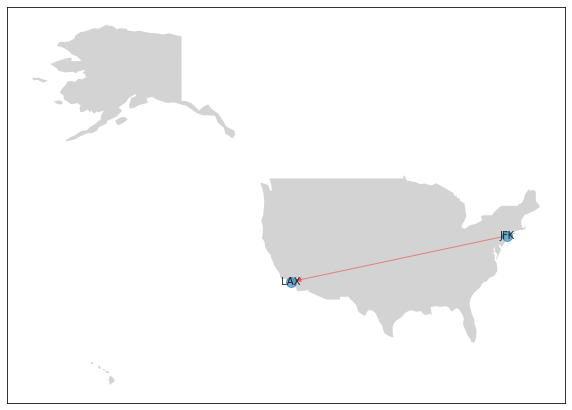

In [7]:
delay_predict(aip_out=aip_out.value,
              year=date_choose.value.year,
              month=date_choose.value.month,
              day=date_choose.value.day,
              hour=hour_choose.value, 
              aip_in=aip_in.value,
              airline=airl.value,
              minute=minute_choose.value)

Если все опциональные поля оставить пустыми - выдается три топ а/п прилета с наименьшими прогнозируемыми опозданиями:

In [8]:
sub_airports = airports[airports.IATA_CODE.isin(flights.query('ORIGIN_AIRPORT == @aip_out.value').DESTINATION_AIRPORT.unique())]
aip_in = wg.Dropdown(options=[(None, None)] + sorted(list(zip(list(map(lambda x: ', '.join(x),
                                                                list(zip(sub_airports.AIRPORT.values,
                                                                         sub_airports.CITY.values)))),
                     sub_airports.IATA_CODE.values))), value=None, description='А/п прилета', disabled=False)

airl = wg.Dropdown(options=[(None, None)] + list(zip(airlines.AIRLINE, airlines.IATA_CODE)),
                   value=None, description='Авиакомпания', disabled=False)

minute_choose = wg.Dropdown(options=list(range(60)), value=0, description='Минуты вылета',
                            disabled=False)

display(aip_in), display(airl), display(minute_choose);

Dropdown(description='А/п прилета', options=((None, None), ('Albuquerque International Sunport, Albuquerque', …

Dropdown(description='Авиакомпания', options=((None, None), ('United Air Lines Inc.', 'UA'), ('American Airlin…

Dropdown(description='Минуты вылета', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1…

Из данного аэропорта можно улететь по 64 направлению/ям, вот топ 3 с минимальными опозданиями:


,DESTINATION_AIRPORT,AIRPORT,CITY,STATE,pred_DEL
0,LGB,Long Beach Airport (Daugherty Field),Long Beach,CA,-14.831269
1,IND,Indianapolis International Airport,Indianapolis,IN,-13.912675
2,SJC,Norman Y. Mineta San José International Airport,San Jose,CA,-11.883237


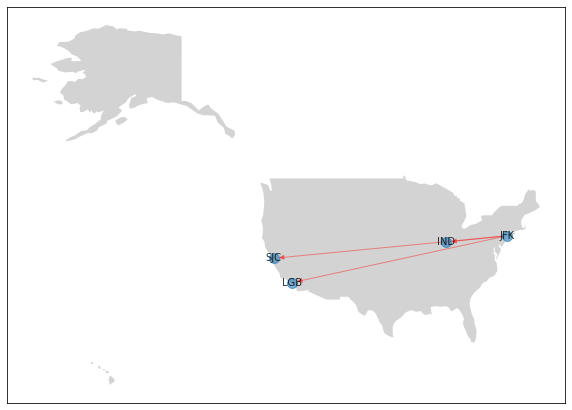

In [9]:
delay_predict(aip_out=aip_out.value,
              year=date_choose.value.year,
              month=date_choose.value.month,
              day=date_choose.value.day,
              hour=hour_choose.value, 
              aip_in=aip_in.value,
              airline=airl.value,
              minute=minute_choose.value)

Если заполнить только а/п прилета, то выдается три топ авиакомпании, летающие по данному маршруту, с минимальными прогнозируемыми задержками:

In [10]:
sub_airports = airports[airports.IATA_CODE.isin(flights.query('ORIGIN_AIRPORT == @aip_out.value').DESTINATION_AIRPORT.unique())]
aip_in = wg.Dropdown(options=[(None, None)] + sorted(list(zip(list(map(lambda x: ', '.join(x),
                                                                list(zip(sub_airports.AIRPORT.values,
                                                                         sub_airports.CITY.values)))),
                     sub_airports.IATA_CODE.values))), value=None, description='А/п прилета', disabled=False)

airl = wg.Dropdown(options=[(None, None)] + list(zip(airlines.AIRLINE, airlines.IATA_CODE)),
                   value=None, description='Авиакомпания', disabled=False)

minute_choose = wg.Dropdown(options=list(range(60)), value=0, description='Минуты вылета',
                            disabled=False)

display(aip_in), display(airl), display(minute_choose);

Dropdown(description='А/п прилета', options=((None, None), ('Albuquerque International Sunport, Albuquerque', …

Dropdown(description='Авиакомпания', options=((None, None), ('United Air Lines Inc.', 'UA'), ('American Airlin…

Dropdown(description='Минуты вылета', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1…

Из данного аэропорта можно улететь 5 авиакомпаниями/ей, вот топ 3 с минимальными опозданиями:


,AIRLINE_x,AIRLINE_y,pred_DEL
0,B6,JetBlue Airways,-2.556278
1,VX,Virgin America,-1.563654
2,AA,American Airlines Inc.,1.924269


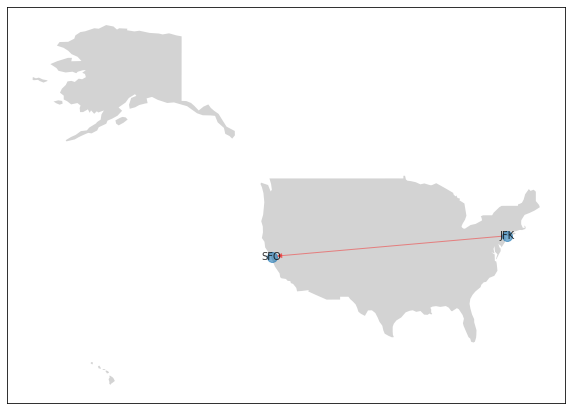

In [11]:
delay_predict(aip_out=aip_out.value,
              year=date_choose.value.year,
              month=date_choose.value.month,
              day=date_choose.value.day,
              hour=hour_choose.value, 
              aip_in=aip_in.value,
              airline=airl.value,
              minute=minute_choose.value)